## Plot trend maps of Sea Level Pressure for the Arctic

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os, glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Get Data

In [3]:
data_dir = '/disks/arctic5_raid/abarrett/MERRA2/monthly/SLP'
fileList = glob.glob(os.path.join(data_dir, 'MERRA2_???.tavgM_2d_slv_Nx.SLP.??????.nc4'))
ds = xr.open_mfdataset(fileList, concat_dim='time')

In [456]:
def _season_time_index(t):
    """
    Calculate time index for central month of season
    """
    return [dt.datetime(y, m+1, 1) if m < 12 else dt.datetime(y+1, 1, 1) for y, m in zip(t.dt.year, t.dt.month)]
        
def month_to_season(x):
    """
    Calculates a time series of seasonal averages for a n-dimensional DataArray
    
    x - xarray DataArray or Dataset
    """
    
    if ds['SLP'].time.dt.month[0] != 1:
        print ('Expects first month to be January')

    # Calculate first DJF average - uses just Jan and Feb data 
    first = x.isel(time=slice(None,2)).mean(dim='time').expand_dims('time')
    first['time'] = [x.time.values[0]]
    
    other = x.isel(time=slice(2,None)).resample(time='3M', closed='right').mean()
    other['time'] = _season_time_index(other.time)
    
    return xr.concat([first,other], dim='time')


## Calculate Seasonal Averages

In [457]:
styyk = ds['SLP'].sel(lat=65.,lon=22.75, method='nearest').load()

In [458]:
styyk_Ssn = month_to_season(styyk)

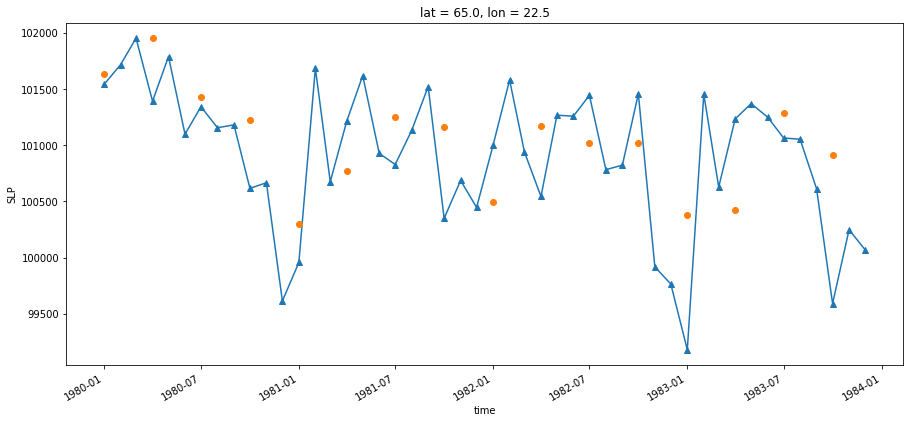

In [459]:
fig, ax = plt.subplots(figsize=(15,7))
styyk[0:48].plot.line('-^',ax=ax)
styyk_Ssn[0:16].plot.line('o', ax=ax)


In [460]:
print (styyk.values[0:15])
print (styyk_Ssn.values[0:5])

[101540.76  101716.34  101951.56  101391.01  101787.78  101097.984
 101341.91  101154.92  101180.26  100615.67  100665.52   99613.82
  99956.06  101684.16  100675.23 ]
[101628.546875  101951.5625    101425.5859375 101225.6953125
 100298.3359375]


In [461]:
styyk_Ssn.time[0:8]

<xarray.DataArray 'time' (time: 8)>
array(['1980-01-01T00:30:00.000000000', '1980-04-01T00:00:00.000000000',
       '1980-07-01T00:00:00.000000000', '1980-10-01T00:00:00.000000000',
       '1981-01-01T00:00:00.000000000', '1981-04-01T00:00:00.000000000',
       '1981-07-01T00:00:00.000000000', '1981-10-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    lat      float64 65.0
    lon      float64 22.5
  * time     (time) datetime64[ns] 1980-01-01T00:30:00 1980-04-01 1980-07-01 ...

## Plot seasonal averages for Sanity

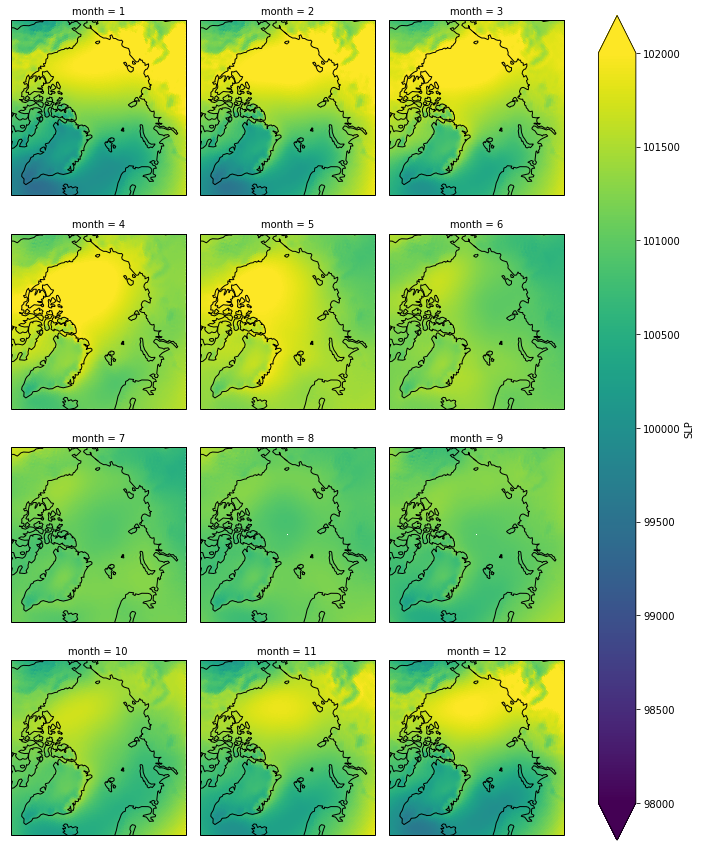

In [5]:
map_proj = ccrs.NorthPolarStereo()

p = dsAvg['SLP'].plot(transform=ccrs.PlateCarree(), col='month', col_wrap=3,
        vmin=98000, vmax=102000,
        aspect=1, subplot_kws={'projection': map_proj})

for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
    # Without this aspect attributes the maps will look chaotic and the
    # "extent" attribute above will be ignored
    ax.set_aspect('equal', 'box-forced')

    


# Calculate linear trend using just xarray functions

In [188]:
def _predict(t, slope, intercept):
    
    x = xr.DataArray(t.to_pandas().index.to_julian_date().values, coords=[t], dims=['time'])
    return x*slope + intercept
    
def _linear_trend(x):
    
    import scipy.stats
    
    nt = x.shape[0]
    
    t = x.time.to_pandas().index.to_julian_date().values
    tanom = xr.DataArray(t - t.mean(), coords=[x.time], dims=['time'])
    
    xanom = x - x.mean(dim='time')
    
    tvar = (tanom*tanom).sum(dim='time')/ (nt-1)  #xss
    xvar = (xanom**2).sum(dim='time') / (nt-1) #yss
    covar = (tanom * xanom).sum(dim='time') / (nt-1) #xys
    
    slope = covar / tvar
    intercept = x.mean(dim='time') - t.mean()*slope
    
    df = nt-2
    r = covar / (tvar * xvar)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    
    p = xr.apply_ufunc(scipy.stats.t.sf, t, df, dask='allowed')
    
    ds = xr.Dataset({'slope': slope,
                     'intercept': intercept,
                     'p': p})
    return ds


In [189]:
trend = ds['SLP'].groupby('time.month').apply(_linear_trend)

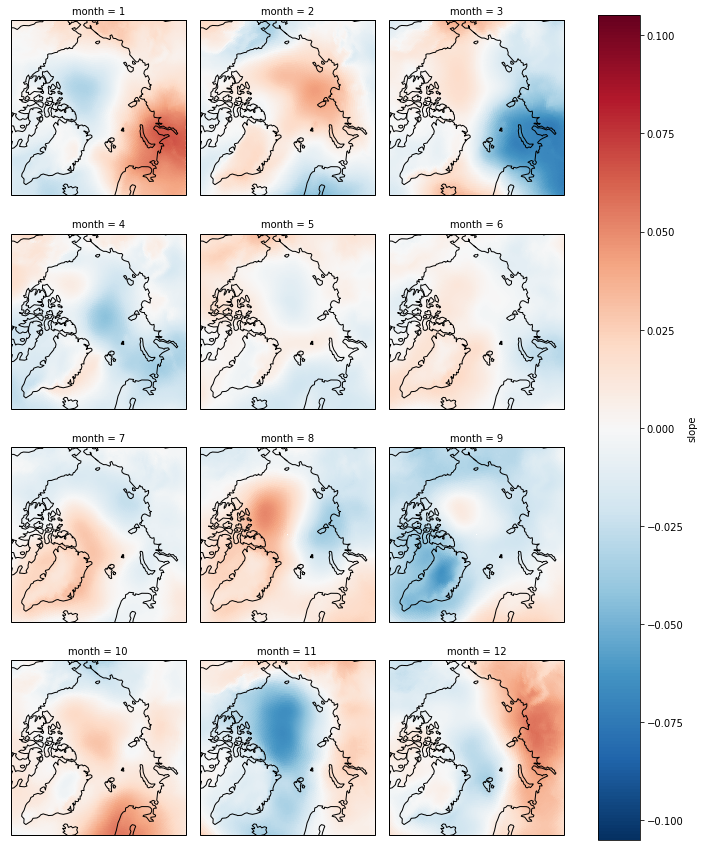

In [205]:
map_proj = ccrs.NorthPolarStereo()

p = trend['slope'].plot(transform=ccrs.PlateCarree(), col='month', col_wrap=3,
        aspect=1, subplot_kws={'projection': map_proj})

for im, ax in enumerate(p.axes.flat):
    
    #ax.contour(trend['p'].sel(month=im+1), transform=ccrs.PlateCarree(), 
    #           levels=[0.9], colors='g')

    ax.coastlines()
    ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
    # Without this aspect attributes the maps will look chaotic and the
    # "extent" attribute above will be ignored
    ax.set_aspect('equal', 'box-forced')

    